In [2]:
import tensorflow as tf
import tensorflow_io as tfio
# import matplotlib
import matplotlib.pyplot as plt

import math

import numpy as np
import sounddevice as sd

import youtube_dl

import librosa
from copy import deepcopy

%matplotlib inline

DURATION = 3 * 60 # 3 minute songs
SAMPLE_RATE = 44100 # my FLAC sample rate
AVERAGE_BPM = 120
CHANNELS = 2


In [3]:
def get_from_url(url):
	ydl_opts = {
		'format': 'bestaudio/best',
		# 'keepvideo': 'false',
		'forcefilename': 'true',
		'outtmpl': '%(id)s.%(ext)s',
		'postprocessors': [{
			'key': 'FFmpegExtractAudio',
			'preferredcodec': 'mp3',
			'preferredquality': '192',
		}],
	}
	with youtube_dl.YoutubeDL(ydl_opts) as ydl:
		song_info = ydl.extract_info(url)
		# print(song_info)
		# print(ydl.download([url]))
	return "{}.mp3".format(song_info['id'])

In [4]:
audio_file = get_from_url("https://www.youtube.com/watch?v=crrM2I34lgA")

# audio_file = filenames[3]
print(audio_file)

audio, sr = librosa.core.load(audio_file, sr=None, mono=False )
audio = (tf.cast(tfio.audio.AudioIOTensor(audio_file).to_tensor(),dtype=tf.float32)/32768.0).numpy().T

print(sr)
print(audio.shape)

[youtube] crrM2I34lgA: Downloading webpage
[youtube] crrM2I34lgA: Downloading player 113ca41c
crrM2I34lgA.webm
[download] Destination: crrM2I34lgA.webm
[download] 100% of 2.29MiB in 00:28                  
[ffmpeg] Destination: crrM2I34lgA.mp3
Deleting original file crrM2I34lgA.webm (pass -k to keep)
crrM2I34lgA.mp3


c:\Code\Python\Python39\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


48000
(2, 6519606)


In [2]:
frame_step = 128
frame_length= 255
def get_spectrogram(waveform, pad: bool = True, input_samples= DURATION * SAMPLE_RATE ):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  channels = waveform.shape[1]
  input_len = input_samples
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      input_samples - waveform.shape[0],
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  spectrogram = []
  for channel in range(channels):
    data = waveform[:-1,channel]
    if pad:
        data = tf.concat([waveform[:,channel], zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram.append(tf.signal.stft(
        data, frame_length=frame_length, frame_step=frame_step))
    # Obtain the magnitude of the STFT.
    spectrogram[channel] = tf.abs(spectrogram[channel])
    spectrogram[channel] = spectrogram[channel][..., tf.newaxis]
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    # spectrogram = spectrogram[..., tf.newaxis]
	# shape ('width', 'batch_size', 'height')
  return tf.concat(spectrogram, axis=2)

In [3]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

(2, 62014, 129)
(62014, 129)


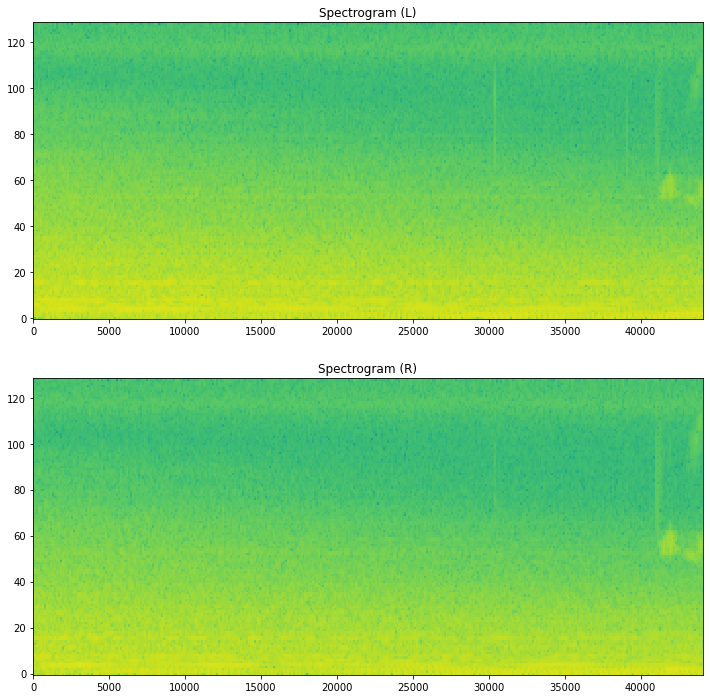

In [4]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
spectrogram = np.transpose(get_spectrogram(audio.T), (-1, 0, 1))
print(spectrogram.shape)

fig, axes = plt.subplots(2, figsize=(12, 12))
S_dB = librosa.power_to_db(spectrogram, ref=np.max)
print(spectrogram[1].shape)
# print(spectrogram.numpy()[...,1])
# print(spectrogram.numpy())
plot_spectrogram(spectrogram[0], axes[0])
axes[0].set_title('Spectrogram (L)')
axes[0].set_xlim([0, sr])
plot_spectrogram(spectrogram[1], axes[1])
axes[1].set_title('Spectrogram (R)')
axes[1].set_xlim([0, sr])
plt.show()

In [5]:
def mse(A,B):
	mean = (np.squeeze(A - B)**2).mean()
	# print(mean)
	return mean
vmse = np.vectorize(mse, signature='(m),(m)->()')
def matmse(A,B):
	return vmse(A,B).reshape(-1,1)
vmatmse = np.vectorize(matmse, signature='(m),(n,m)->(n,1)')

In [6]:
l_tempo, r_tempo = np.squeeze(librosa.beat.tempo(y=audio))
print(l_tempo, r_tempo)
tempo = math.ceil((l_tempo+r_tempo)/2)

_, beat_track = librosa.beat.beat_track(y=librosa.to_mono(audio), sr=sr, tightness=1, hop_length=256, trim=False, units="samples")
print(beat_track.shape)

time_stamps =librosa.samples_to_time(beat_track, sr=sr)

print(np.array(beat_track).reshape((-1,1)).shape)
# print(beat_track)
# print(time_stamps)
print(tempo)

129.19921875 129.19921875
(489,)
(489, 1)
130


In [7]:
print(beat_track[0])
print(beat_track[10])
print(audio[:,int(beat_track[0]):int(beat_track[2])].T.shape)
sd.play(audio[:,int(beat_track[0]):int(beat_track[2])].T,sr)
sd.wait()

1280
163584
(45824, 2)


In [8]:
from itertools import tee, islice, chain
def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)

In [9]:
spectrogram = get_spectrogram(audio.T, pad=False)
samples = spectrogram.shape[0]
duration = ((audio.shape[1]/sr)/60)
beats = beat_track.shape[0]

total_samples = math.ceil(samples/beats) * beats

beat_samples = np.array([np.mean(get_spectrogram(audio[:,p_sample:sample].T, pad=False), axis=0) for p_sample, sample, n_sample in previous_and_next(beat_track)])
print(beat_samples.shape)


zero_padding = np.zeros((total_samples - samples, spectrogram.shape[1], spectrogram.shape[2]))

spectrogram = np.concatenate([spectrogram, zero_padding])

print(duration)
print(beats)
print(samples)
print(total_samples)

samples_per_beat = np.array(np.split(spectrogram, beats))
beats_spectrogram = np.mean(samples_per_beat, axis=1)
# print(samples_per_beat.shape)
print(beats_spectrogram.shape)

# mse_arrays = [np.concatenate([np.zeros((i,1)),vmatmse(beats_spectrogram[i,:,1],beats_spectrogram[i:,:,1])]) for i in range(beats)]
mse_arrays = [np.concatenate([np.zeros((i,1)),vmatmse(beat_samples[i,:,1],beat_samples[i:,:,1])]) for i in range(beats)]

mse_mat = np.column_stack(mse_arrays)
print(mse_mat.shape)

mse_mat_nonzero = np.where(mse_mat==0, mse_mat.max(), mse_mat)
# best_match_index = np.reshape(np.argmin(mse_mat_nonzero, axis=1), (-1, 1))
# best_match_value = np.reshape(np.min(mse_mat_nonzero, axis=1), (-1, 1))
# print(best_match_index)

# best_match = (np.reshape(np.min(np.where(mse_mat==0, mse_mat.max(), mse_mat), axis=1), (-1,1)))

(489, 129, 2)
3.2288726379440664
489
62014
62103
(489, 129, 2)
(489, 489)


In [10]:
source_beat = np.tile(np.arange(beats), (beats, 1)).T
end_beat = np.tile(np.arange(beats), (beats, 1))
beat_to_beat_mse = np.stack([source_beat, mse_mat, end_beat], axis=2)
beat_to_beat_map = beat_to_beat_mse[beat_to_beat_mse[:,:, 1] > 0]
beat_to_beat_map_sorted = beat_to_beat_map[beat_to_beat_map[:, 1].argsort()]
print(source_beat.shape)
print(end_beat.shape)
print(beat_to_beat_map.shape)

(489, 489)
(489, 489)
(119316, 3)


In [11]:
gap = 15
best_match_map_long = beat_to_beat_map_sorted[(beat_to_beat_map_sorted[:, 0] - beat_to_beat_map_sorted[:, 2]) > gap]
print(best_match_map_long.shape)
# print(best_match_map_long)

(112101, 3)


In [120]:
play_buffer = deepcopy(audio).T
print(play_buffer.shape)

(8543597, 2)


In [117]:
quality = 95 # 100 - 0
best_match_map_filtered = beat_to_beat_map_sorted[(beat_to_beat_map_sorted[:, 0] -beat_to_beat_map_sorted[:, 2]) > gap]
best_match_map_filtered = best_match_map_filtered[:int(best_match_map_filtered.shape[0] * (min(max(100-quality, 1), 99)/100)), :]
print(best_match_map_filtered.shape)

(5605, 3)


In [118]:
# diff = 0
# while diff < 50:
# 	n = 1
# 	indices = np.random.choice(best_match_index.shape[0], n, replace=False)
# 	from_beat = indices.squeeze()
# 	to_beat = best_match_index[indices].squeeze()
# 	diff = abs(from_beat-to_beat)
index = 12
from_beat = int(best_match_map_filtered[index][0])
to_beat = int(best_match_map_filtered[index][2])
print(from_beat)
print(to_beat)
# best_match_index.choose()

218
135


In [122]:
pad = 10
from_beat_begin = max(from_beat-pad, 0)
from_beat_end = from_beat
to_beat_begin = to_beat
to_beat_end = min(to_beat+pad, beat_track.shape[0])
from_sample_begin = beat_track[from_beat_begin]
from_sample_end = beat_track[from_beat_end]
to_sample_begin = beat_track[to_beat_begin]
to_sample_end = beat_track[to_beat_end]
# print(np.concatenate([np.arange(from_beat_begin, from_beat_end),np.arange(to_beat_begin, to_beat_end) ]))
clip = np.concatenate([play_buffer[from_sample_begin:from_sample_end,:], play_buffer[to_sample_begin:to_sample_end,:]], axis=0)
print(clip.shape)

(358400, 2)


In [16]:
sd.play(clip.T, sr)
sd.wait()

In [123]:
from queue import Queue
from threading import Thread
# from asyncio import Queue
clip_queue = Queue()
initial_buffer = np.concatenate([play_buffer[:,:from_sample_end], play_buffer[:, to_sample_begin:]], axis=1).T
initial_queue_list = list(map(clip_queue.put, initial_buffer[:400000,:]))
print(initial_buffer[400000:,:].shape)

(0, 8543597)


In [187]:
pos = 0
output = True
# Theoretically, we don't need a queue
# The branches allowed
# branch_prob = 0.2
best_match_map_filtered_by_beat = best_match_map_filtered[best_match_map_filtered[:, 0].argsort()]
# print(branches)
def audioGenerator(output, pos):
	changed = True
	def generateBranchProbability(size=1, branches=None, change=None):
		branches[:] = np.random.randn(size, 1)
		change= True
	
	branches = np.zeros((best_match_map_filtered.shape[0], 1))
	on_branch = Thread(target=lambda : print("Branched"))
	branch_prob_thread = Thread(target= generateBranchProbability, args=(best_match_map_filtered_by_beat.shape[0],branches,changed))
	branch_prob_thread.start()
	branch_prob_thread.join()
	# branch_index = np.squeeze(np.argmax(branches))
	# [from_beat,_, to_beat]=best_match_map_filtered_by_beat[branch_index]
	while output:
		# print(pos)
		# if it should branch to another point in the song
		# i.e. set pos to another sample
		# print(branch_index)
		# print(from_beat)
		# print(to_beat)
		# print(pos)
		# from_beat = play_buffer.shape[0]
		# print(changed)
		# print(from_beat)
		if(changed):
			branch_index = np.squeeze(np.argmax(branches))
			[from_beat,_, to_beat]=best_match_map_filtered_by_beat[branch_index]
			changed= False
		if(pos % 10000 == 0):
			print(changed)
			print(branch_index)
			print("Next Branch: {}[{}] -> {}[{}]".format(int(from_beat), beat_track[int(from_beat)], int(to_beat), beat_track[int(to_beat)]))
		if pos == beat_track[int(from_beat)]:
			data = play_buffer[beat_track[int(to_beat)],:]
			pos = beat_track[int(to_beat)] + 1
			on_branch.start()
			branch_prob_thread.start()
		else:
			data = play_buffer[pos,:]
			pos+=1

		if(pos >= play_buffer.shape[0]):
			output = False
		yield data, pos

In [192]:
sample_frame = 0
duration = 180.5  # seconds
# Can load till first branch 
# list(map(clip_queue.put, np.concatenate([play_buffer[:,:from_sample_end], play_buffer[:, to_sample_begin:]], axis=1).T))
gen = audioGenerator(output, pos)
# print(next(gen))
def audio_callback(indata: np.ndarray, outdata: np.ndarray, frames: int, time, status: sd.CallbackFlags):
	if status:
		print(status)
	
	outdata[:] = np.array([next(gen)[0] for _ in range(frames)])

stream = sd.Stream(samplerate=sr, channels=2, callback=audio_callback)
stream.start()
stream

# add_to_queue_thread = Thread(target=add_data)
# add_to_queue_thread.start()
# await add_data()
# sd.sleep(int(duration * 1000))
# stream.stop()
# audio_stream.stop()

False
1690
Next Branch: 298[5357056] -> 51[762112]


TypeError: object Stream can't be used in 'await' expression

In [193]:

stream.stop()

False
1690
Next Branch: 298[5357056] -> 51[762112]
